### Recurrent Neural Network representation of C. elegans neural timeseries data
Script to model C. elegans neural timeseries data,
and generate similar data, using a Recurrent
Neural Network (specifically, a long short term memory or LSTM network)

Inspired by
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Based on code from
https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import os

%matplotlib inline
import matplotlib.pyplot as plt

os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

#Add the src folder to the sys.path list
sys.path.append('../src/')
import data_config as dc

In [16]:
wormData = dc.kato_matlab.retrieve()

print(wormData)

                                                                   0  \
FlNm               TS20140715f_lite-1_punc-31_NLS3_3eggs_56um_1mM...   
NeuronIds                   0     1
0     None  None
1     None  ...   
deltaFOverF        [[0.135913490458, 0.122698371026, 0.1273345364...   
deltaFOverF_bc     [[0.0813810375536, 0.068289481621, 0.073049190...   
deltaFOverF_deriv  [[-0.000551819232698, -0.000551818672615, -0.0...   
tv                 [[0.0, 0.344607530313, 0.689215060625, 1.03382...   

                                                                   1  \
FlNm               TS20140926d_lite-1_punc-31_NLS3_RIV_2eggs_1mMT...   
NeuronIds                   0      1
0     None   None
1     None...   
deltaFOverF        [[-0.0888920088322, -0.130398703723, -0.080847...   
deltaFOverF_bc     [[0.11694110675, 0.0756448955127, 0.1254065656...   
deltaFOverF_deriv  [[0.0062459423014, 0.00624604574426, 0.0062471...   
tv                 [[0.0, 0.326185442465, 0.652370884929, 0.978

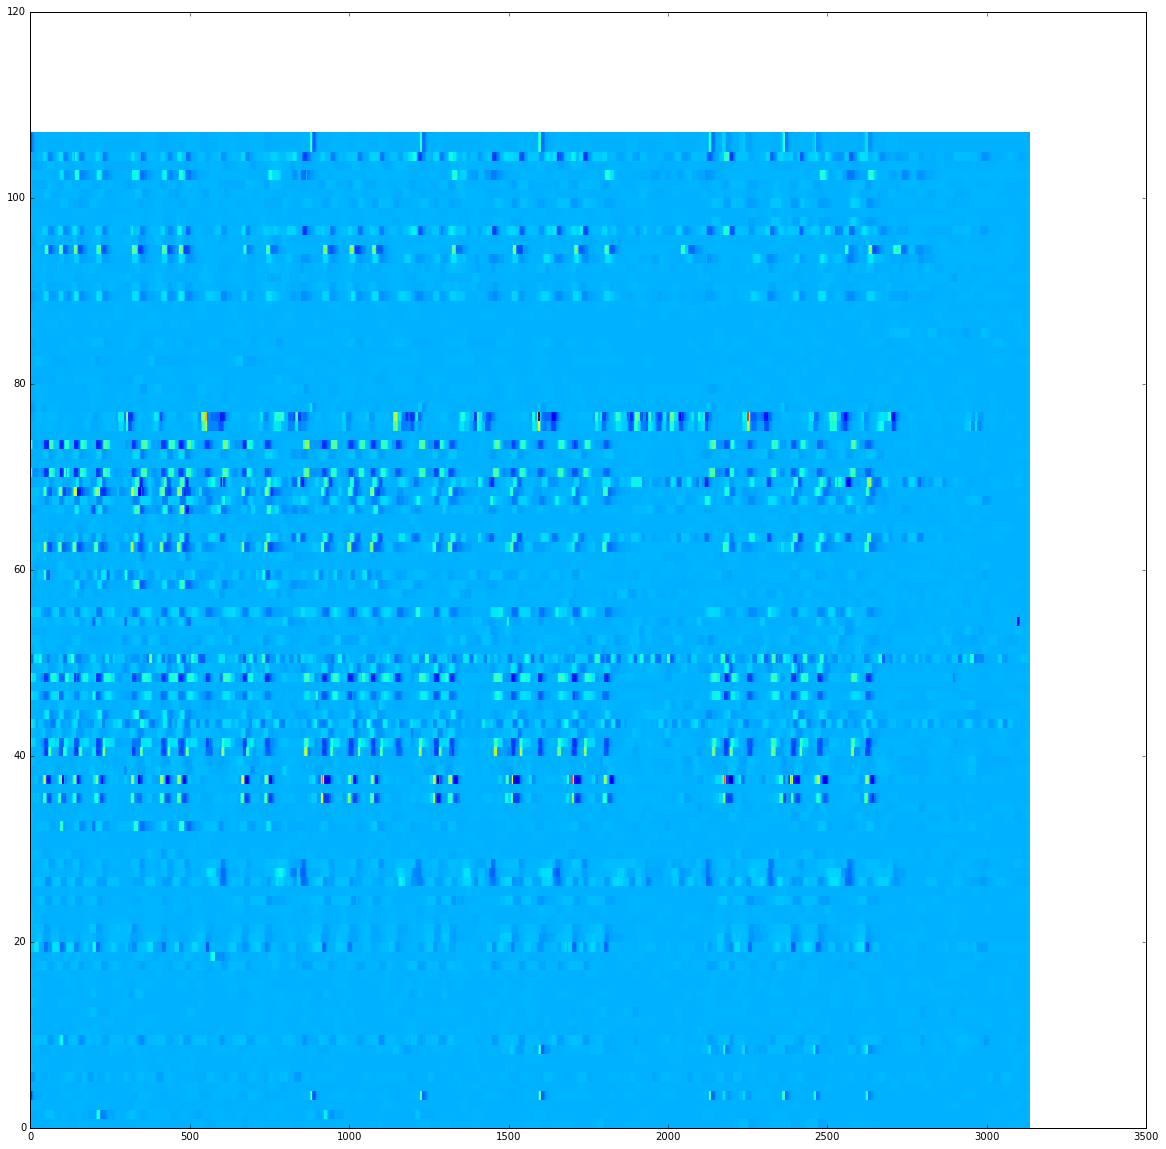

In [17]:
# Choose a trial arbitrarily
# Let's try with derivative data

seq = wormData[0]["deltaFOverF_deriv"].T
plt.figure(figsize=(20,20))
plt.pcolor(seq.T)


In [18]:
# Cut the timeseries data (variable name 'seq') into semi-redundant sequence chunks of maxlen
maxlen = 10

X = []
y = []

for i in range(0, len(seq) - maxlen):
    X.append(seq[i:i+maxlen])
    y.append(seq[i+maxlen])

dim = len((X[0][0]))

print("sequence chunks:", len(X))
print("chunk width:", len(X[0]))
print("vector dimension:", dim)

X = np.array(X)
y = np.array(y)

('sequence chunks:', 3124)
('chunk width:', 10)
('vector dimension:', 107)


In [19]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, dim)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(dim))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Build model...


In [23]:
# Train the model
model.fit(X, y, batch_size=128, nb_epoch=50)

Epoch 1/50
3124/3124 [==============================] - 21s - loss: -1.1050    
Epoch 2/50
3124/3124 [==============================] - 19s - loss: -1.1836    
Epoch 3/50
3124/3124 [==============================] - 21s - loss: -1.2238    
Epoch 4/50
3124/3124 [==============================] - 19s - loss: -1.2658    
Epoch 5/50
3124/3124 [==============================] - 20s - loss: -1.3218    
Epoch 6/50
3124/3124 [==============================] - 19s - loss: -1.3812    
Epoch 7/50
3124/3124 [==============================] - 20s - loss: -1.4335    
Epoch 8/50
3124/3124 [==============================] - 20s - loss: -1.4618    
Epoch 9/50
3124/3124 [==============================] - 19s - loss: -1.4696    
Epoch 10/50
3124/3124 [==============================] - 19s - loss: -1.4967    
Epoch 11/50
3124/3124 [==============================] - 21s - loss: -1.5134    
Epoch 12/50
3124/3124 [==============================] - 20s - loss: -1.5247    
Epoch 13/50
3124/3124 [==============

In [24]:
# Generate timeseries
x_seed = X[len(X)-1] #choose final in-sample data point to initialize model
x_array = []
x_array.append(x_seed)
x = np.array(x_array)

generated = []
for i in range(50):
    pred = model.predict(x, verbose=0)[0].tolist()

    #drop oldest data in x, and append predicted data for feedforward into model
    j = []
    x = []
    for i in range(1, len(x_seed)):    
        j.append(x_seed[i])
    j.append(pred)
    x = []
    x.append(j)
    x = np.array(x)
    generated.append(pred)

generated = np.array(generated)

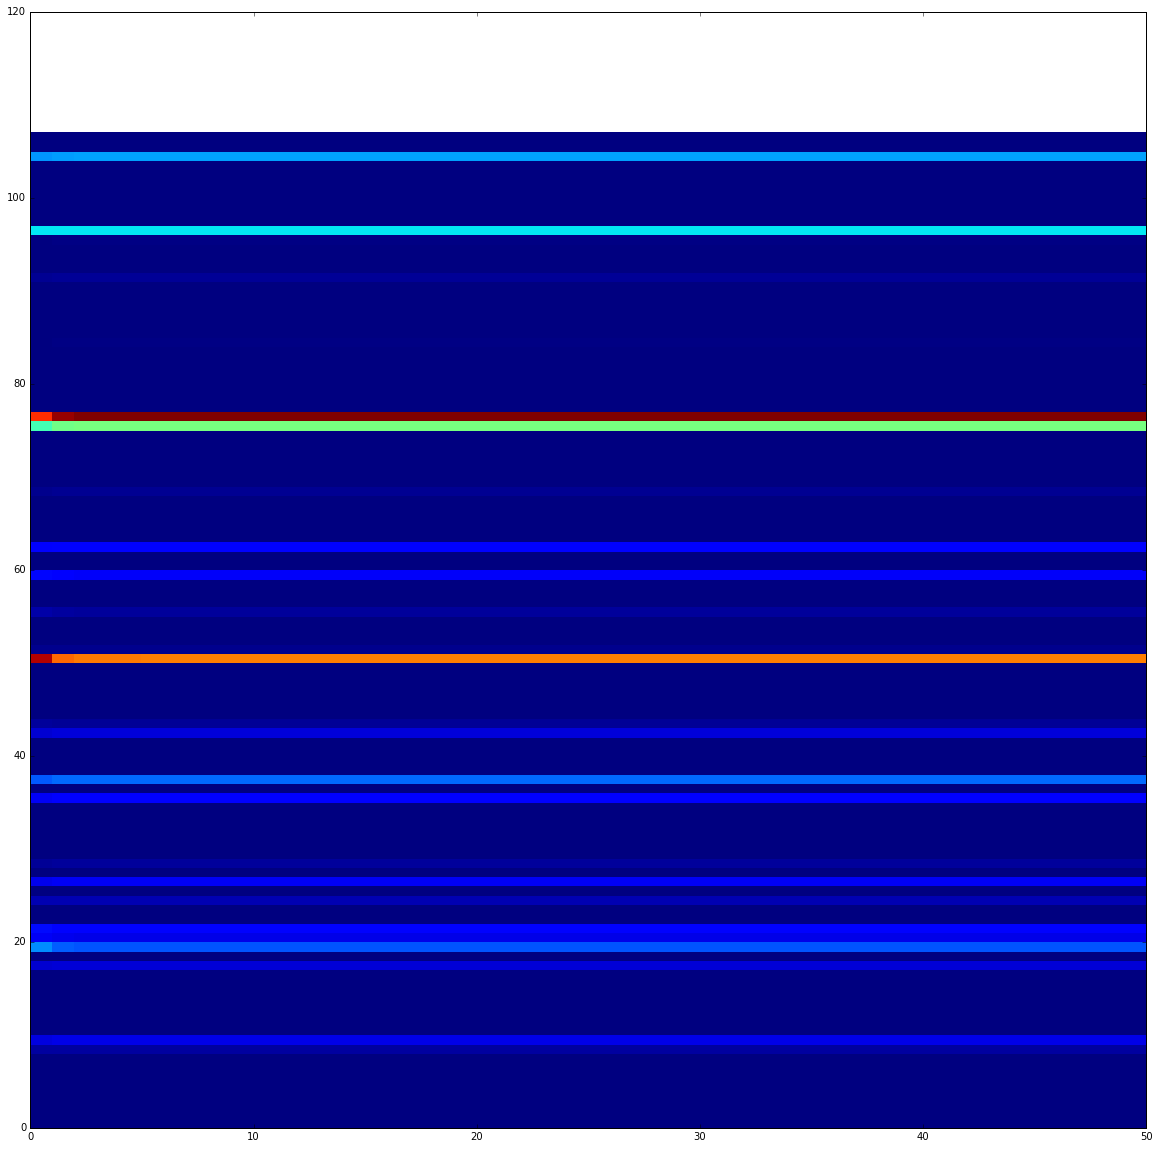

In [33]:
plt.figure(figsize=(20,20))
plt.pcolor(generated.T)